In [43]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,3)


In [44]:
fig_size = plt.rcParams["figure.figsize"]

In [45]:
fig_size

[20.0, 3.0]

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

In [3]:
train_df = pd.read_csv('./train_data.tsv',sep='\t')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20010 entries, 0 to 20009
Data columns (total 5 columns):
일자      20010 non-null int64
time    20010 non-null object
식사내용    20010 non-null object
매출일자    20010 non-null float64
수량      20010 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 781.7+ KB


In [4]:
time_dummy = pd.get_dummies(train_df['time'])

In [5]:
train_df = pd.concat([train_df, time_dummy],axis=1)

In [6]:
num_values = 7
degrees_week = np.linspace(0, 360, num_values + 1)[:-1]
print(degrees_week)
sin_week = np.sin(np.deg2rad(degrees_week))
print(sin_week)
cos_week = np.cos(np.deg2rad(degrees_week))
print(cos_week)

num_values = 12
degrees_month = np.linspace(0, 360, num_values + 1)[:-1]
print(degrees_month)
sin_month = np.sin(np.deg2rad(degrees_month))
print(sin_month)
cos_month = np.cos(np.deg2rad(degrees_month))
print(cos_month)

num_values = 31
degrees_day = np.linspace(0, 360, num_values + 1)[:-1]
print(degrees_day)
sin_day = np.sin(np.deg2rad(degrees_day))
print(sin_day)
cos_day = np.cos(np.deg2rad(degrees_day))
print(cos_day)

[   0.           51.42857143  102.85714286  154.28571429  205.71428571
  257.14285714  308.57142857]
[ 0.          0.78183148  0.97492791  0.43388374 -0.43388374 -0.97492791
 -0.78183148]
[ 1.          0.6234898  -0.22252093 -0.90096887 -0.90096887 -0.22252093
  0.6234898 ]
[   0.   30.   60.   90.  120.  150.  180.  210.  240.  270.  300.  330.]
[  0.00000000e+00   5.00000000e-01   8.66025404e-01   1.00000000e+00
   8.66025404e-01   5.00000000e-01   1.22464680e-16  -5.00000000e-01
  -8.66025404e-01  -1.00000000e+00  -8.66025404e-01  -5.00000000e-01]
[  1.00000000e+00   8.66025404e-01   5.00000000e-01   6.12323400e-17
  -5.00000000e-01  -8.66025404e-01  -1.00000000e+00  -8.66025404e-01
  -5.00000000e-01  -1.83697020e-16   5.00000000e-01   8.66025404e-01]
[   0.           11.61290323   23.22580645   34.83870968   46.4516129
   58.06451613   69.67741935   81.29032258   92.90322581  104.51612903
  116.12903226  127.74193548  139.35483871  150.96774194  162.58064516
  174.19354839  185.806

In [7]:
def make_coord(date,num_class):
    # 1 ~ 12, 1 ~ 7, 1 ~ 31
    degrees = np.linspace(0,360,num_values + 1)[:-1]
    sin = np.sin(np.deg2rad(degrees))
    cos = np.cos(np.deg2rad(degrees))
    return sin, cos


def date2coord(date, sin, cos):
    return cos[date-1], sin[date-1]


def date2week(x):
    y = int(str(x)[:4])
    m = int(str(x)[4:6])
    d = int(str(x)[6:])
    day = datetime(y, m, d)
    return day.weekday()

In [8]:
train_df['month'] = train_df['일자'].apply(lambda x:int(str(x)[4:6]))
train_df['day'] = train_df['일자'].apply(lambda x:int(str(x)[6:]))
train_df['week'] = train_df['일자'].apply(date2week)
train_df['week'] = train_df['week'] + 1 

In [9]:
train_df['day_coord'] = train_df['day'].apply(date2coord, args=(sin_day, cos_day,))
train_df['month_coord'] = train_df['month'].apply(date2coord, args=(sin_month, cos_month))
train_df['week_coord'] = train_df['week'].apply(date2coord, args=(sin_week, cos_week,))

In [10]:
x_list = []

In [11]:
X_arr = np.array(train_df['day_coord'].apply(lambda x:np.array(x)).tolist())
x_list.append(X_arr)

In [12]:
X_arr = np.array(train_df['month_coord'].apply(lambda x:np.array(x)).tolist())
x_list.append(X_arr)

In [13]:
X_arr = np.array(train_df['week_coord'].apply(lambda x:np.array(x)).tolist())
x_list.append(X_arr)

In [14]:
X_arr = train_df['아침'].values.reshape(-1,1)
x_list.append(X_arr)
X_arr = train_df['점심'].values.reshape(-1,1)
x_list.append(X_arr)
X_arr = train_df['점심2'].values.reshape(-1,1)
x_list.append(X_arr)
X_arr = train_df['저녁'].values.reshape(-1,1)
x_list.append(X_arr)

In [15]:
X_arr.shape

(20010, 1)

In [16]:
doc_list = train_df['식사내용'].apply(lambda x: ' '.join(x[:-1].split(','))).tolist()

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=2000,ngram_range=range(1,3))

In [18]:
X_food = vectorizer.fit_transform(doc_list)

print(X_food.shape)

(20010, 2000)


In [19]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

In [20]:
svd = TruncatedSVD(n_components=1000)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd,normalizer)

In [21]:
X_lsa = lsa.fit_transform(X_food)

exp_var = svd.explained_variance_ratio_.sum()

In [22]:
print(X_lsa.shape, exp_var)

(20010, 1000) 0.90180187046


In [23]:
X_coord = np.concatenate(x_list,axis=1)
y = train_df['수량'].values.reshape(-1,1)
print(X_coord.shape, y.shape)

(20010, 10) (20010, 1)


In [24]:
from scipy import sparse

In [25]:
X_food.shape

(20010, 2000)

In [26]:
X = np.concatenate([X_lsa, X_coord],axis=1)

In [27]:
#X = sparse.hstack((X_lsa,X_coord))

In [28]:
X.shape

(20010, 1010)

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [30]:
model = LinearRegression(normalize=True)

In [31]:
cross_val_score(model,X=X,y=y,cv=5, verbose=True,scoring='mean_squared_error')

/Users/1003874/anaconda/envs/gcp-vision/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/1003874/anaconda/envs/gcp-vision/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/1003874/anaconda/envs/gcp-vision/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/1003874/anaconda/envs/gcp-vision/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

array([-309.06355132,  -61.11977812,  -58.65015682,  -62.24723919,
       -118.26773243])

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,)
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.63940381160103943

In [56]:
print("RMSE: %.2f"% math.sqrt(np.mean(( model.predict(X_test) - y_test) ** 2)))

RMSE: 6.99


In [57]:
print("RMSE: %.2f"% math.sqrt(np.mean(( model.predict(X_train) - y_train) ** 2)))

RMSE: 6.72


In [58]:
pred = model.predict(X_test)

In [59]:
fig = plt.figure(figsize=(18, 3))

/Users/1003874/anaconda/envs/gcp-vision/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


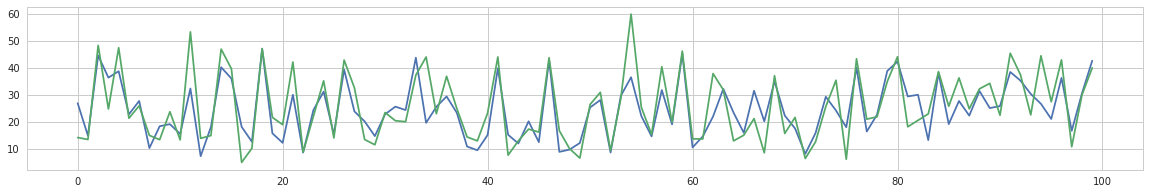

In [60]:
plt.plot(pred[100:200])
plt.plot(y_test[100:200])

### xgboost

In [34]:
import xgboost

In [35]:
xgb = xgboost.XGBRegressor(n_estimators=100, booster='gblinear', learning_rate=0.1, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=3, n_job=4)

In [36]:
%%time
xgb.fit(X_train,y_train)

CPU times: user 1.76 s, sys: 16.9 ms, total: 1.77 s
Wall time: 1.78 s


XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_job=4, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.75)

In [37]:
print("RMSE: %.2f"% math.sqrt(np.mean((xgb.predict(X_test) - y_test) ** 2)))

RMSE: 12.01


### svr

In [38]:
from sklearn.svm import LinearSVR

In [39]:
clf = LinearSVR(C=1.0,epsilon=0.2, max_iter=100000,tol=0.000001)
clf.fit(X_train, y_train)

/Users/1003874/anaconda/envs/gcp-vision/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVR(C=1.0, dual=True, epsilon=0.2, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=100000,
     random_state=None, tol=1e-06, verbose=0)

In [40]:
print("RMSE: %.2f"% math.sqrt(np.mean((clf.predict(X_test) - y_test) ** 2)))

RMSE: 14.75
